Add the package to the path.

In [1]:
import sys
sys.path.append("/home/ace07/Documents/GitHub/QMPRS")
sys.path.append("/home/ace07/Documents/GitHub/QICKIT")

Import `qmprs` modules. For this demo, we will import the MPS instance.

In [2]:
from qickit.circuit import Circuit, QiskitCircuit, CirqCircuit, PennylaneCircuit, TKETCircuit
from qickit.primitives import Ket

from qmprs.mps import MPS
from qmprs.synthesis.mps_encoding import Sequential

/home/ace07/Documents/GitHub/QMPRS/.venv/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


We will also import some basic modules for additional calculations and plotting.

In [3]:
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

### MPS Demo : Creating and manipulating Matrix Product States (MPS)

This notebook is dedicated to the demonstration of how `qmprs` can be used to create and manipulate matrix product states (MPS). In this notebook, we will go over the main functionalities of the `MPS` class and how it can be used at the high level to perform conventional MPS operations. This will set the intuition for how MPS can be used in gate-based quantum computing applications to perform state preparation or unitary synthesis.

At a high level, MPS [[3]] can be understood as an approximation of a tensor network where we represent the approximation as the product of a series of matrices. This is useful for quantum computing where we represent quantum states as 1D tensors, and quantum operators as matrices operating on 1D tensors. We can use MPS to approximate a given quantum state (and similarly a Matrix Product Operator (MPO) to approximate a quantum operator) given some measure $\chi$ called the bond dimension, whereby increasing the bond dimension we can reach higher fidelity approximations but at the cost of larger matrices. Conventionally, the cost of an MPS is as follows:

Circuit depth = $O(dN\chi^2)$

Where $d$ is the physical dimension of the state (which is equal to 2 for qubit-based representation), and $N$ is the number of qubits required to represent the state. At a glance, one can infer that given a constant bond dimension the cost of preparing the state scales linearly with the number of qubits, which is an exponential reduction compared to the usual exact encoding schema seen in [[1]] and [[2]].

[1]: https://
[2]: https://
[3]: https://

Below is an example of how we can create an MPS for some arbitrary quantum state. For ease in assessing the fidelity of the MPS, we will use images and compare the original image with the extracted image after constructing the MPS, and calculate the fidelity of the two using a simple inner product. For this example, we will use a Fashion MNIST datapoint.

In [4]:
# Load in the resized MNIST dataset
dataset = pd.read_csv('datasets/mnist-resized.csv')

# Convert the dataset to a numpy array
images = dataset.to_numpy()[:,1:].reshape(30018, 8, 8)

# Get the first image
test_image = images.reshape(30018, 8, 8)[0, :]

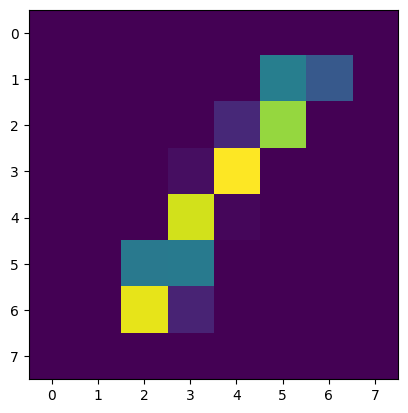

In [5]:
plt.imshow(test_image)

Next, we will convert this image to a quantum state using `qickit.primitives.Ket`. `qmprs` is built with `qickit` in mind, hence a great amount of the package utilizes the codebase built in `qickit`.

In [6]:
# Create a `qickit.primitives.Ket` instance
state = Ket(test_image.flatten())

# Create a `qmprs.mps.MPS` instance
mps = MPS(statevector=state, bond_dimension=8)

We can then reconstruct the state vector using `.to_statevector()` method.

/tmp/ipykernel_399726/3231258830.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  state = MPS.to_statevector(mps.mps).data.astype(float)


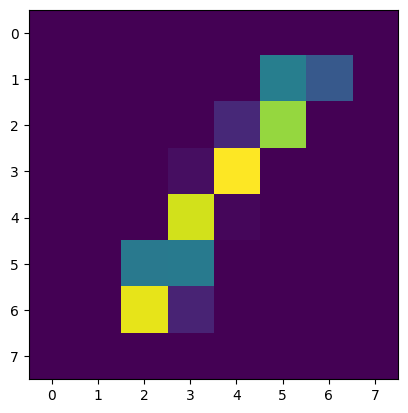

In [7]:
state = MPS.to_statevector(mps.mps).data.astype(float)

plt.imshow(state.reshape(8, 8))

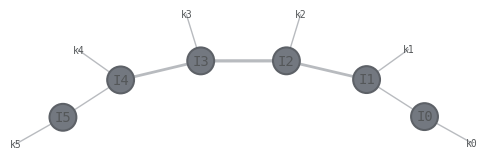

MatrixProductState(tensors=6, indices=11, L=6, max_bond=5)

In [8]:
mps.draw()

mps.mps

In [9]:
sequential_encoder = Sequential(TKETCircuit)
circuit = sequential_encoder.prepare_mps(mps, num_layers=32)

In [10]:
statevector = circuit.get_statevector().astype(float)

print(statevector)

[-8.43929222e-05  1.57199204e-04  4.68279380e-05 -5.26350673e-07
 -4.89148335e-05  8.00627060e-05 -2.93961068e-05  6.14044280e-05
  5.64433749e-05  4.13087226e-05  9.02427348e-05  4.98953014e-05
  1.80112903e-05  2.10659005e-01  1.37065154e-01  1.64859200e-05
  6.06389528e-06  3.35623848e-05 -1.57751251e-04  1.40396732e-04
  5.60205784e-02  4.15390394e-01 -1.18583880e-04 -9.11818865e-05
 -6.66970060e-05  1.11138044e-04 -6.51162151e-05  1.77234992e-02
  4.92593196e-01 -1.29377334e-04  1.33694190e-04  6.70241754e-05
 -3.92235595e-05 -8.46990266e-06 -4.13544569e-05  4.58486794e-01
  7.66164849e-03  1.89798313e-05 -9.43898475e-05 -9.35423646e-05
 -7.45537348e-05 -7.08233565e-05  1.98919041e-01  2.00578647e-01
 -3.00596492e-05  4.68172610e-05 -8.30394539e-06 -9.14529179e-06
 -5.34233378e-05  1.54972085e-06  4.75186374e-01  4.81059315e-02
 -5.08609599e-05 -9.07181318e-05  1.33522071e-05  4.43997458e-05
  1.07833224e-05 -3.32985451e-07 -6.34361040e-05 -3.19326087e-05
 -2.88848493e-05  1.83113

/tmp/ipykernel_399726/2575581218.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  statevector = circuit.get_statevector().astype(float)


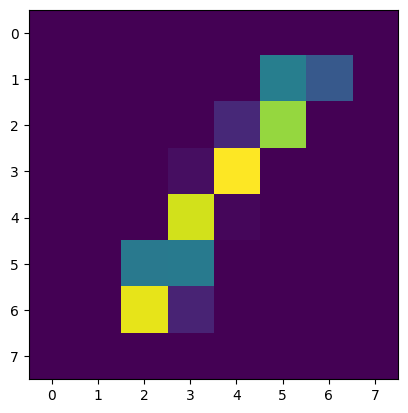

In [11]:
plt.imshow(statevector.reshape(8, 8))

In [13]:
np.dot(statevector, state)

array([0.99999968])

In [12]:
circuit.get_depth()

397

Let's see how the synthesis fidelity and cost scale as we increase the number of layers.

In [11]:
layers = range(1, 33)
fidelities = []
depths = []

sequential_encoder = Sequential(QiskitCircuit)

for layer in layers:
    circuit = sequential_encoder.prepare_mps(mps, num_layers=layer)
    statevector = circuit.get_statevector().astype(float)
    fidelity = np.dot(state.T, statevector)
    fidelities.append(fidelity)
    depths.append(circuit.get_depth())

/tmp/ipykernel_168423/1697238362.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  statevector = circuit.get_statevector().astype(float)


Text(0, 0.5, 'Fidelity')

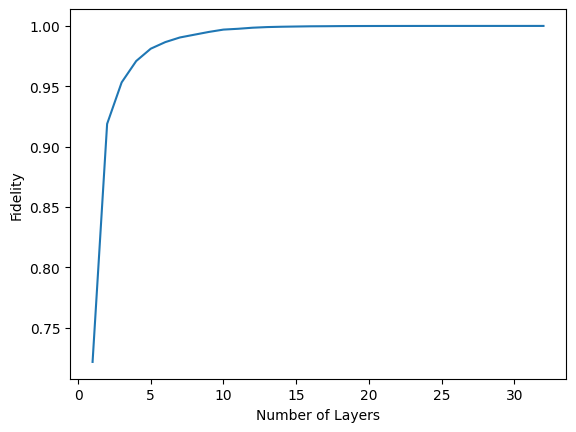

In [12]:
plt.plot(layers, fidelities)
plt.xlabel('Number of Layers')
plt.ylabel('Fidelity')

Text(0, 0.5, 'Depth')

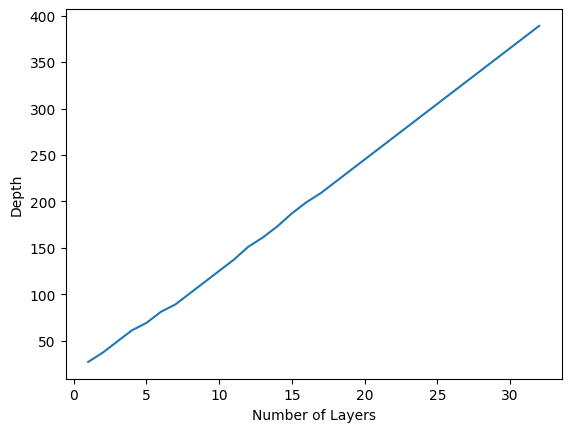

In [13]:
plt.plot(layers, depths)
plt.xlabel('Number of Layers')
plt.ylabel('Depth')

We can see that the synthesis scales linearly with respect to the number of layers specified. Bear in mind that the sequential implementation presented in `qmprs` differs slightly from the traditional approaches, where instead of specifying the bond dimension in the synthesis we specify the number of unitary layers used to synthesize the target MPS.

In [4]:
sequential_encoder = Sequential(QiskitCircuit)

def generate_random_state(num_qubits: int) -> NDArray[np.complex128]:
    data = np.random.rand(2**num_qubits) + 1j * np.random.rand(2**num_qubits)
    data /= np.linalg.norm(data)
    return data

def encode_state(state: NDArray[np.complex128],
                 num_layers: int,
                 bond_dimension: int) -> tuple[Circuit, float]:
    mps = MPS(statevector=state, bond_dimension=bond_dimension)

    circuit = sequential_encoder.prepare_mps(mps, num_layers=num_layers)
    print(circuit.num_qubits)
    statevector = circuit.get_statevector()

    fidelity = abs(np.dot(state.conj(), statevector))

    return circuit, fidelity

def generate_plot(max_num_qubits: int,
                  max_error: float) -> tuple[list[float], list[int]]:
    num_qubits = range(1, max_num_qubits + 1)
    fidelities = []
    depths = []

    bond_dimension = 2**10

    for qubits in tqdm(num_qubits):
        num_layers = 8
        state = generate_random_state(qubits)
        circuit, fidelity = encode_state(state, num_layers, bond_dimension)

        while fidelity < 1 - max_error:
            print(f"Fidelity for {num_layers} layers, {bond_dimension} bond dimension, with {max_error} max error is : {fidelity}")

            num_layers *= 2
            if fidelity < 0.9:
                bond_dimension *= 2
                circuit, fidelity = encode_state(state, num_layers, bond_dimension)
            circuit, fidelity = encode_state(state, num_layers, bond_dimension)

        fidelities.append(fidelity)
        depths.append(circuit.get_depth())

    return fidelities, depths

In [5]:
fidelities, depths = generate_plot(10, 0.05)

  0%|          | 0/10 [00:00<?, ?it/s]

 70%|███████   | 7/10 [00:56<00:41, 13.80s/it]

Fidelity for 8 layers, 1024 bond dimension, with 0.05 max error is : 0.9446367420275862


 80%|████████  | 8/10 [13:42<08:26, 253.21s/it]

Fidelity for 8 layers, 1024 bond dimension, with 0.05 max error is : 0.917318194373308
Fidelity for 16 layers, 1024 bond dimension, with 0.05 max error is : 0.9457763978010272


 90%|█████████ | 9/10 [4:52:35<1:30:05, 5405.07s/it]

Fidelity for 8 layers, 1024 bond dimension, with 0.05 max error is : 0.8987236368465213
Fidelity for 16 layers, 2048 bond dimension, with 0.05 max error is : 0.9210114260795079


100%|██████████| 10/10 [5:08:03<00:00, 1848.30s/it] 


Text(0, 0.5, 'Fidelity')

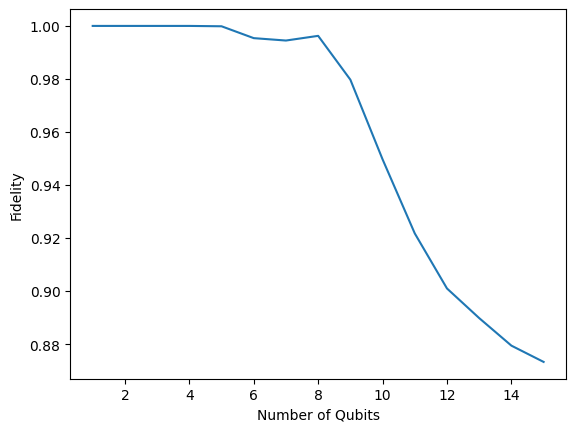

In [6]:
plt.plot(range(1, 16), fidelities)
plt.xlabel('Number of Qubits')
plt.ylabel('Fidelity')

Text(0, 0.5, 'Depth')

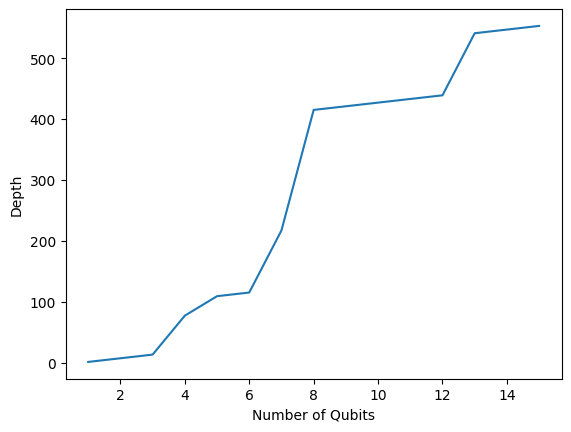

In [8]:
plt.plot(range(1, 16), depths)
plt.xlabel('Number of Qubits')
plt.ylabel('Depth')

Text(0, 0.5, 'Fidelity')

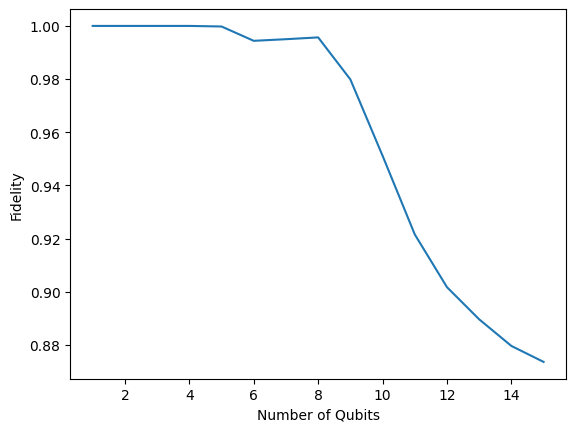

In [16]:
plt.plot(range(1, 16), fidelities)
plt.xlabel('Number of Qubits')
plt.ylabel('Fidelity')

Text(0, 0.5, 'Depth')

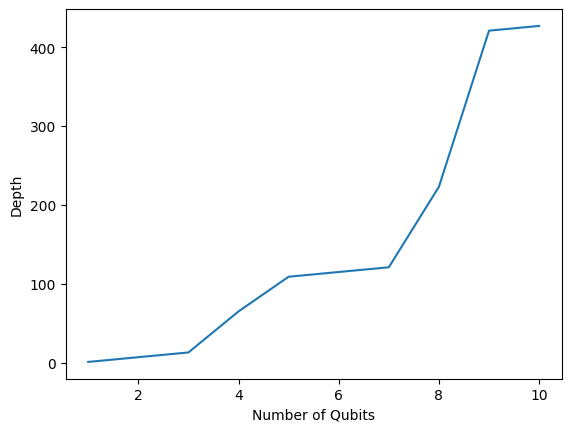

In [7]:
plt.plot(range(1, 11), depths)
plt.xlabel('Number of Qubits')
plt.ylabel('Depth')

Text(0, 0.5, 'Depth')

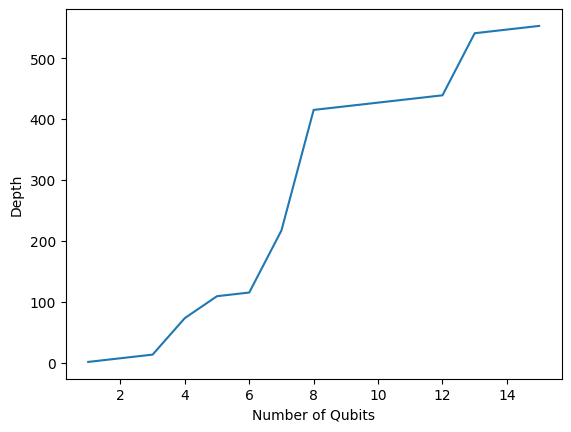

In [17]:
plt.plot(range(1, 16), depths)
plt.xlabel('Number of Qubits')
plt.ylabel('Depth')

We can see that the relation between the number of layers and number of qubits is exponential, which is expected given that we still incur an exponential cost for preparing the unitary layers themselves. Note that thanks to the MPS approximation we observe a significantly reduced growth when compared to the exponential growth of exact encoders such as Mottonen.

In [7]:
num_layers = [8, 8, 8, 8, 8, 8, 16, 32, 32, 32, 32, 32, 40, 40]

num_qubits = range(1, 15)

depths = []
fidelities = []

for qubit in tqdm(num_qubits):
    state = generate_random_state(qubit)
    circuit, fidelity = encode_state(state, num_layers[qubit-1], 8192)
    fidelities.append(fidelity)
    depths.append(circuit.get_depth())

14 14 14


100%|██████████| 14/14 [1:47:01<00:00, 458.65s/it] 


In [ ]:
num_layers = [8, 8, 8, 8, 8, 8, 16, 32, 32, 32, 32, 32, 40, 40]

num_qubits = range(1, 15)

depths = []
fidelities = []

for qubit in tqdm(num_qubits):
    state = generate_random_state(qubit)
    circuit, fidelity = encode_state(state, num_layers[qubit-1], 128)
    fidelities.append(fidelity)
    depths.append(circuit.get_depth())

In [26]:
num_layers = [1, 2, 4, 8, 16, 32, 64, 128]

state = generate_random_state(5)
depths = []
fidelities = []

for layer in tqdm(num_layers):
    circuit, fidelity = encode_state(state, layer, 32)
    fidelities.append(fidelity)
    depths.append(circuit.get_depth())

100%|██████████| 8/8 [14:53:11<00:00, 6698.93s/it] 


Text(0, 0.5, 'Fidelity')

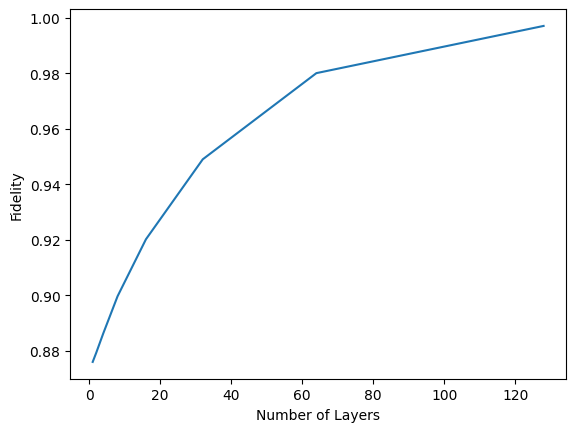

In [28]:
# Bond dimension 32
plt.plot(num_layers, fidelities)
plt.xlabel('Number of Layers')
plt.ylabel('Fidelity')

Text(0, 0.5, 'Fidelity')

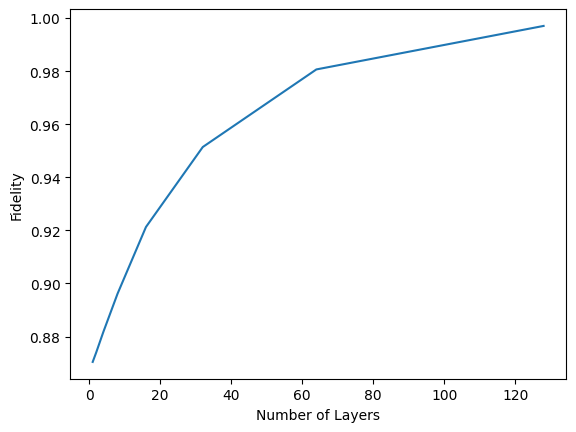

In [25]:
# Bond dimension 128
plt.plot(num_layers, fidelities)
plt.xlabel('Number of Layers')
plt.ylabel('Fidelity')

### Scenario 1 : Fidelity and scaling of the encoding with constant bond dimension and number of qubits and increasing number of layers.

#### Test case 1

In [11]:
sequential_encoder = Sequential(TKETCircuit)

num_layers = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]

state = generate_random_state(11)
depths = []
fidelities = []

for layer in tqdm(num_layers):
    circuit, fidelity = encode_state(state, layer, 8)
    fidelities.append(fidelity)
    depths.append(circuit.get_depth())

  0%|          | 0/12 [00:00<?, ?it/s]

11


  8%|▊         | 1/12 [00:00<00:09,  1.16it/s]

11


 17%|█▋        | 2/12 [00:02<00:11,  1.15s/it]

11


 25%|██▌       | 3/12 [00:07<00:26,  2.96s/it]

11


 33%|███▎      | 4/12 [00:13<00:32,  4.07s/it]

11


 42%|████▏     | 5/12 [00:27<00:55,  7.92s/it]

11


 50%|█████     | 6/12 [01:04<01:46, 17.73s/it]

11


 58%|█████▊    | 7/12 [02:52<03:55, 47.17s/it]

11


 67%|██████▋   | 8/12 [08:53<09:48, 147.10s/it]

11


 75%|███████▌  | 9/12 [31:18<26:04, 521.44s/it]

11


 83%|████████▎ | 10/12 [1:52:58<1:02:26, 1873.37s/it]

11


 92%|█████████▏| 11/12 [6:08:48<1:39:57, 5997.94s/it]

11


100%|██████████| 12/12 [10:30:22<00:00, 3151.87s/it] 


In [6]:
# Sanity check : Ensure the plateau is not a depth limitation imposed by TKET
sequential_encoder = Sequential(PennylaneCircuit)

num_layers = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]

state = generate_random_state(11)
depths = []
fidelities = []

for layer in tqdm(num_layers):
    circuit, fidelity = encode_state(state, layer, 8)
    fidelities.append(fidelity)
    depths.append(circuit.get_depth())

  0%|          | 0/12 [00:00<?, ?it/s]

11


  8%|▊         | 1/12 [00:01<00:11,  1.05s/it]

11


 17%|█▋        | 2/12 [00:04<00:25,  2.53s/it]

11


 25%|██▌       | 3/12 [00:12<00:46,  5.11s/it]

11


 33%|███▎      | 4/12 [00:24<01:02,  7.77s/it]

11


 42%|████▏     | 5/12 [00:52<01:45, 15.12s/it]

11


 50%|█████     | 6/12 [02:53<05:07, 51.17s/it]

11


 58%|█████▊    | 7/12 [09:18<13:21, 160.26s/it]

11


 67%|██████▋   | 8/12 [30:37<34:24, 516.22s/it]

11


 75%|███████▌  | 9/12 [1:26:41<1:10:19, 1406.55s/it]

11


 83%|████████▎ | 10/12 [4:39:13<2:31:17, 4538.78s/it]

11


 92%|█████████▏| 11/12 [17:15:01<4:43:48, 17028.29s/it]

11


100%|██████████| 12/12 [31:42:22<00:00, 9511.89s/it]   


In [6]:
state = generate_random_state(11)


In [7]:
# Sanity check : Ensure the plateau is not a depth limitation imposed by TKET
sequential_encoder = Sequential(CirqCircuit)

num_layers = [1, 2, 4, 8, 16, 32, 64]

depths = []
fidelities = []

for layer in tqdm(num_layers):
    circuit, fidelity = encode_state(state, layer, 8)
    fidelities.append(fidelity)
    depths.append(circuit.get_depth())

  0%|          | 0/7 [00:00<?, ?it/s]

11


 14%|█▍        | 1/7 [00:00<00:05,  1.01it/s]

11


 29%|██▊       | 2/7 [00:04<00:13,  2.73s/it]

11


 43%|████▎     | 3/7 [00:09<00:14,  3.56s/it]

11


 57%|█████▋    | 4/7 [00:20<00:19,  6.61s/it]

11


 71%|███████▏  | 5/7 [00:54<00:33, 16.56s/it]

11


 86%|████████▌ | 6/7 [02:50<00:50, 50.28s/it]

11


100%|██████████| 7/7 [10:25<00:00, 89.33s/it] 


In [8]:
print(fidelities)
print(depths)

[0.08615370809543872, 0.09050043918985361, 0.11147458981213851, 0.11917985238048968, 0.14371879556098308, 0.1755914483296844, 0.195412810847707]
[61, 73, 97, 145, 241, 433, 817]


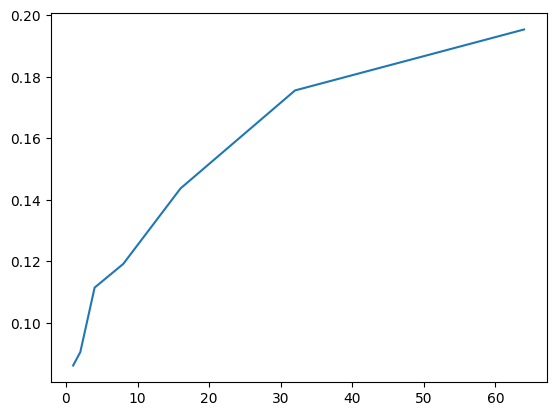

In [9]:
plt.plot(num_layers, fidelities)

In [10]:
# Sanity check : Ensure the plateau is not a depth limitation imposed by TKET
sequential_encoder = Sequential(TKETCircuit)

num_layers = [1, 2, 4, 8, 16, 32, 64]

depths = []
fidelities = []

for layer in tqdm(num_layers):
    circuit, fidelity = encode_state(state, layer, 8)
    fidelities.append(fidelity)
    depths.append(circuit.get_depth())

  0%|          | 0/7 [00:00<?, ?it/s]

11


 14%|█▍        | 1/7 [00:01<00:06,  1.12s/it]

11


 29%|██▊       | 2/7 [00:06<00:18,  3.72s/it]

11


 43%|████▎     | 3/7 [00:09<00:13,  3.40s/it]

11


 57%|█████▋    | 4/7 [00:16<00:14,  4.82s/it]

11


 71%|███████▏  | 5/7 [00:31<00:16,  8.47s/it]

11


 86%|████████▌ | 6/7 [01:12<00:19, 19.35s/it]

11


100%|██████████| 7/7 [03:01<00:00, 25.93s/it]


In [11]:
print(fidelities)
print(depths)

[0.08615370809543868, 0.09050043918985363, 0.1114745898121385, 0.11917985238048968, 0.14371879556098283, 0.17559144832968362, 0.19541281084770448]
[61, 73, 97, 145, 241, 433, 817]


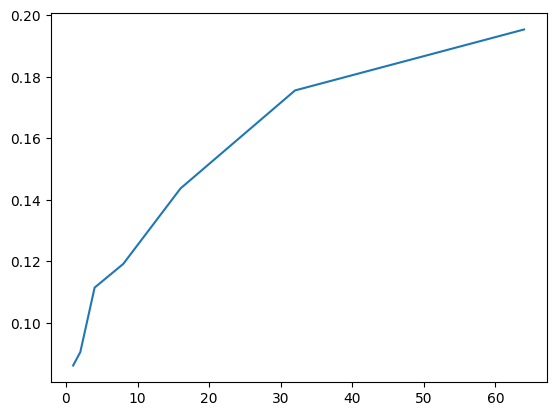

In [12]:
plt.plot(num_layers, fidelities)

In [13]:
# Sanity check : Ensure the plateau is not a depth limitation imposed by TKET
sequential_encoder = Sequential(PennylaneCircuit)

num_layers = [1, 2, 4, 8, 16, 32, 64]

depths = []
fidelities = []

for layer in tqdm(num_layers):
    circuit, fidelity = encode_state(state, layer, 8)
    fidelities.append(fidelity)
    depths.append(circuit.get_depth())

  0%|          | 0/7 [00:00<?, ?it/s]

11


 14%|█▍        | 1/7 [00:00<00:04,  1.30it/s]

11


 29%|██▊       | 2/7 [00:02<00:06,  1.38s/it]

11


 43%|████▎     | 3/7 [00:05<00:08,  2.25s/it]

11


 57%|█████▋    | 4/7 [00:13<00:13,  4.56s/it]

11


 71%|███████▏  | 5/7 [00:36<00:21, 10.98s/it]

11


 86%|████████▌ | 6/7 [01:44<00:30, 30.34s/it]

11


100%|██████████| 7/7 [05:28<00:00, 46.89s/it]


In [14]:
print(fidelities)
print(depths)

[0.08615370809543875, 0.09050043918985368, 0.11147458981213867, 0.11917985238049021, 0.14371879556098427, 0.17559144832968684, 0.1954128108477125]
[61, 73, 97, 145, 241, 433, 817]


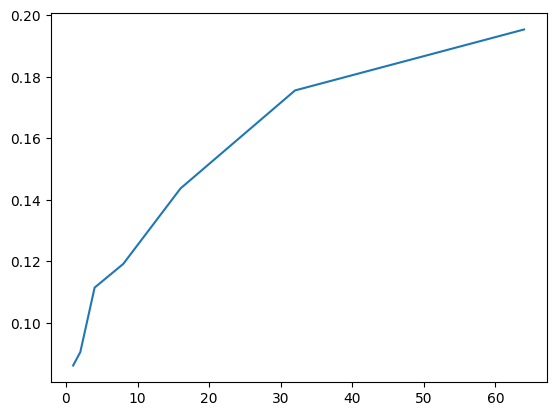

In [15]:
plt.plot(num_layers, fidelities)

In [16]:
# Sanity check : Ensure the plateau is not a depth limitation imposed by TKET
sequential_encoder = Sequential(QiskitCircuit)

num_layers = [1, 2, 4, 8, 16, 32, 64]

depths = []
fidelities = []

for layer in tqdm(num_layers):
    circuit, fidelity = encode_state(state, layer, 8)
    fidelities.append(fidelity)
    depths.append(circuit.get_depth())

  0%|          | 0/7 [00:00<?, ?it/s]

11


 14%|█▍        | 1/7 [00:02<00:14,  2.43s/it]

11


 29%|██▊       | 2/7 [00:07<00:18,  3.75s/it]

11


 43%|████▎     | 3/7 [00:26<00:44, 11.04s/it]

11


 57%|█████▋    | 4/7 [01:20<01:23, 27.82s/it]

11


 71%|███████▏  | 5/7 [04:29<02:52, 86.11s/it]

11


 86%|████████▌ | 6/7 [16:32<05:02, 302.49s/it]

11


100%|██████████| 7/7 [1:04:18<00:00, 551.19s/it] 


In [17]:
print(fidelities)
print(depths)

[0.08615370809543876, 0.09050043918985365, 0.1114745898121387, 0.11917985238049023, 0.14371879556098435, 0.17559144832968687, 0.19541281084771264]
[61, 73, 97, 145, 241, 433, 817]


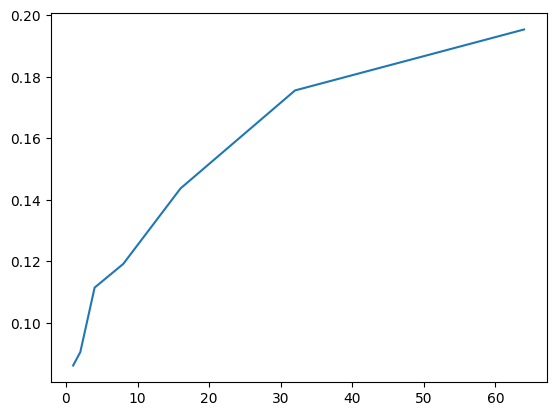

In [18]:
plt.plot(num_layers, fidelities)

#### Test case 2

In [ ]:
sequential_encoder = Sequential(TKETCircuit)

num_layers = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]

state = generate_random_state(9)
depths = []
fidelities = []

for layer in tqdm(num_layers):
    circuit, fidelity = encode_state(state, layer, 8)
    fidelities.append(fidelity)
    depths.append(circuit.get_depth())

#### Test case 3

In [ ]:
sequential_encoder = Sequential(PennylaneCircuit)

num_layers = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]

state = generate_random_state(15)
depths = []
fidelities = []

for layer in tqdm(num_layers):
    circuit, fidelity = encode_state(state, layer, 8)
    fidelities.append(fidelity)
    depths.append(circuit.get_depth())

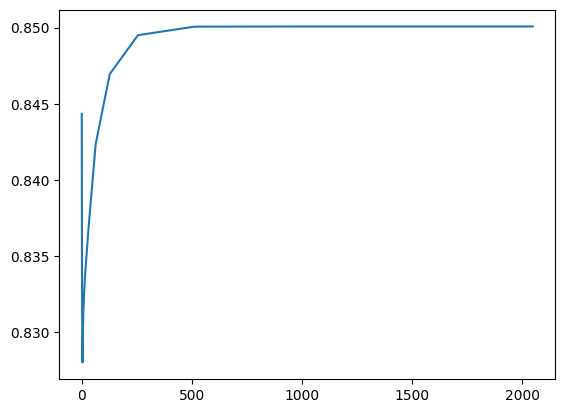

In [22]:
plt.plot(num_layers, fidelities)

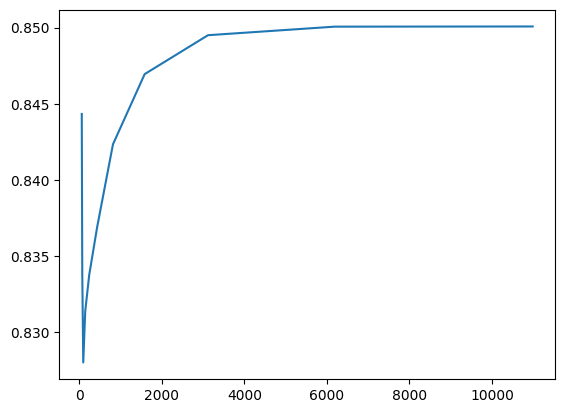

In [13]:
plt.plot(depths, fidelities)

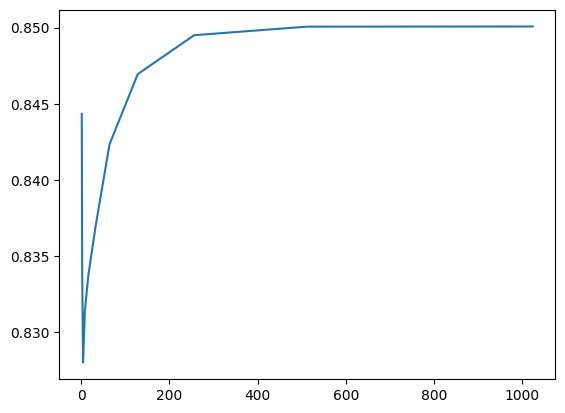

In [24]:
plt.plot(num_layers[:-1], fidelities[:-1])

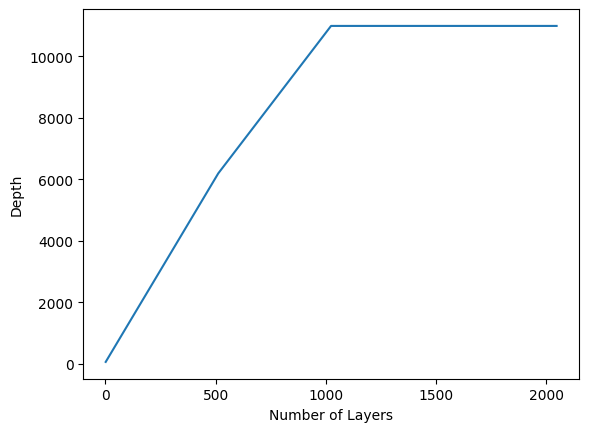

In [20]:
plt.plot(num_layers, depths)
plt.xlabel('Number of Layers')
plt.ylabel('Depth')
plt.show()

In [19]:
depths

[61, 73, 97, 145, 241, 433, 817, 1585, 3119, 6191, 10985, 10985]

In [7]:
depths

[61, 73, 97, 145, 241, 433, 817, 1585, 3121, 6191, 12335, 12953]

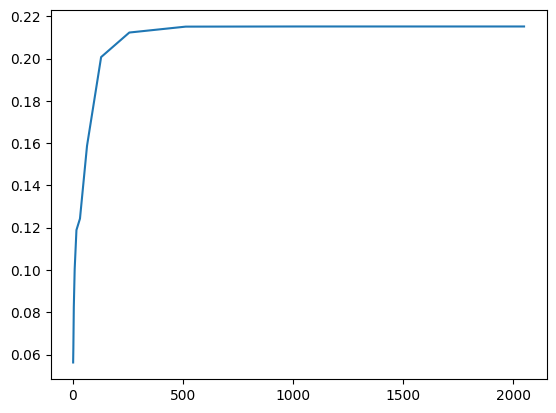

In [8]:
plt.plot(num_layers, fidelities)

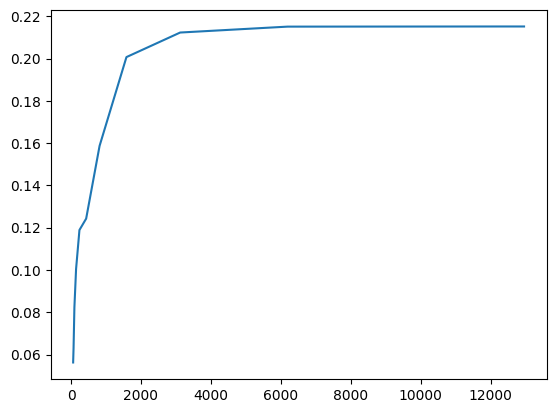

In [9]:
plt.plot(depths, fidelities)

Text(0, 0.5, 'Fidelity')

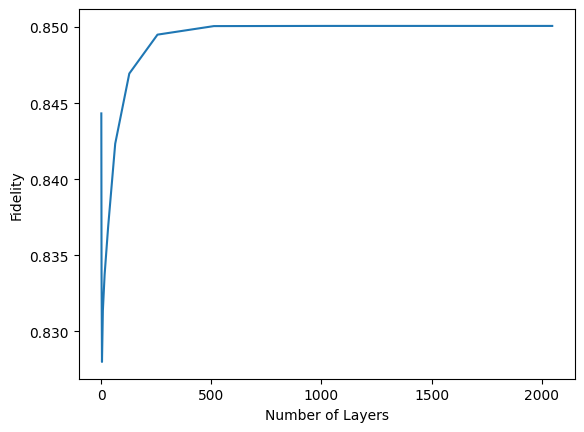

In [18]:
# Bond dimension 32
plt.plot(num_layers, fidelities)
plt.xlabel('Number of Layers')
plt.ylabel('Fidelity')

### Scenario 2 : Comparison of Sequential vs Mottonen scaling

In [8]:
from qickit.synthesis.statepreparation import Mottonen


mottonen = Mottonen(QiskitCircuit)

def generate_random_state(num_qubits: int) -> NDArray[np.complex128]:
    data = np.random.rand(2**num_qubits) + 1j * np.random.rand(2**num_qubits)
    data /= np.linalg.norm(data)
    return data

def generate_plot(num_qubits: int) -> list[int]:
    depths = []

    for qubit in tqdm(range(1, num_qubits+1)):
        state = generate_random_state(qubit)
        circuit = mottonen.prepare_state(state)
        depth = circuit.get_depth()
        depths.append(depth)
    
    return depths

new_depths = generate_plot(14)

  0%|          | 0/14 [00:00<?, ?it/s]

100%|██████████| 14/14 [32:01<00:00, 137.23s/it]


Text(0, 0.5, 'Depth')

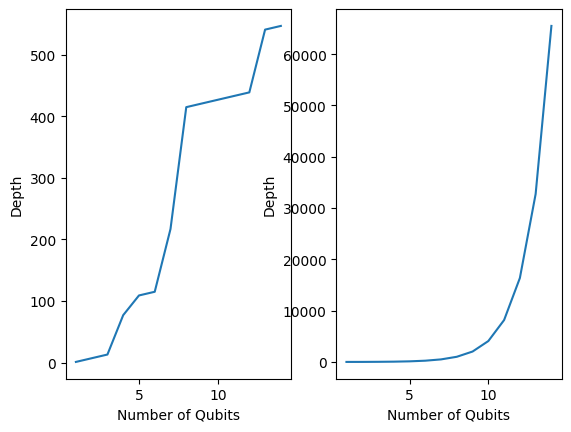

In [10]:
plt.subplot(1, 2, 1)
plt.plot(range(1, 15), depths)
plt.xlabel('Number of Qubits')
plt.ylabel('Depth')

plt.subplot(1, 2, 2)
plt.plot(range(1, 15), new_depths)
plt.xlabel('Number of Qubits')
plt.ylabel('Depth')

Text(0, 0.5, 'Depth')

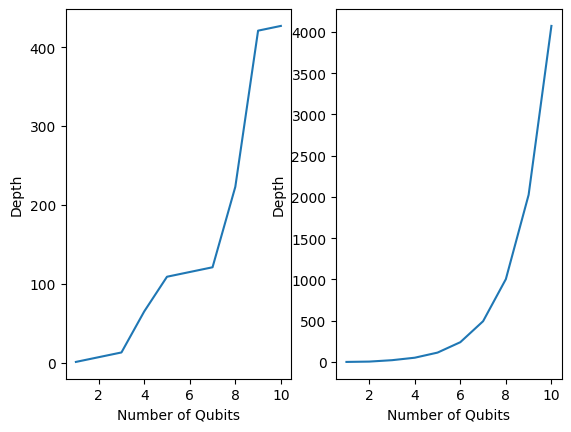

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(range(1, 11), depths)
plt.xlabel('Number of Qubits')
plt.ylabel('Depth')

plt.subplot(1, 2, 2)
plt.plot(range(1, 11), new_depths)
plt.xlabel('Number of Qubits')
plt.ylabel('Depth')

Text(0, 0.5, 'Depth')

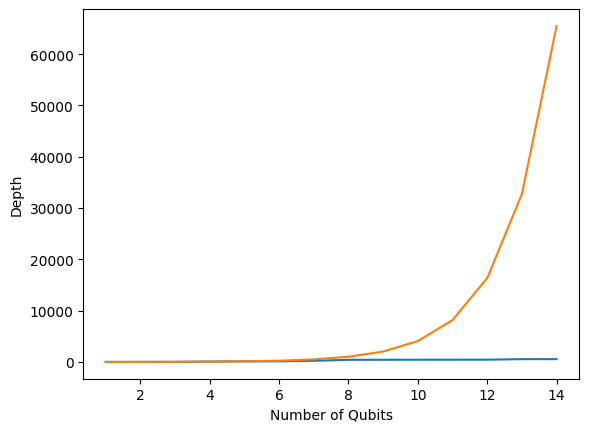

In [11]:
plt.plot(range(1, 15), depths)
plt.plot(range(1, 15), new_depths)
plt.xlabel('Number of Qubits')
plt.ylabel('Depth')

In [12]:
print(depths)
print(new_depths)

[1, 7, 13, 77, 109, 115, 217, 415, 421, 427, 433, 439, 541, 547]
[1, 5, 22, 52, 114, 240, 494, 1004, 2026, 4072, 8166, 16356, 32738, 65504]


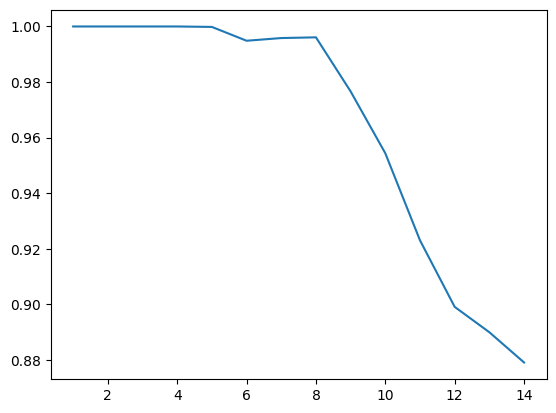

In [13]:
plt.plot(range(1, 15), fidelities)

### Cost Comparison : Exact vs MPS approximation

The sequential synthesis is perhaps the simplest way to synthesize quantum states through the MPS approach. It was initially conceived for long-range correlation which covers a more complete state space than the usual utilizations of MPS encoders which instead focus on short-range correlations almost exclusively. The inclusion of long-range correlation requires more layers, and thus leads to a more expensive implementation.

Now, in comparison to the exact analogues, i.e., [1, 2] by Mottonen and Shende the sequential MPS seemingly requires more depth (present as we see with 32 layers, we need 389 depth, whereas when using Mottonen or Shende we can do the same with 128 depth. A significant difference). This is due to the fact that MPS is not meant for exact encoding, and nor does it need to do so. MPS is useful as it allows us to approximate the statevectors using a linear number of parameters as opposed to the exponential requirement present with [1, 2]. This means that we can never truly do an exact encoding with MPS, and thus as we increase the layers more and more, we only get more cost at negligible fidelity. MPS instead enables the synthesis with an almost exponential reduction in cost with a small loss in fidelity. That means instead of pushing for 100 percent fidelity we can instead settle for 99, and reduce the cost in this case to 101 using 8 layers or so.

Furthermore, the sequential MPS can be perceived as the least efficient way to perform synthesis. This is primarily due to being restricted to unitary operations only. With more recent publications [3, 4], we can see a more emphasized focus on utilizing non-unitary operators in quantum circuits in the form of mid-circuit measurements. As presented in [3], approaches with mid-circuit measurement can indeed reach a much lower depth scaling, i.e., $log(N)$ which is itself another exponential reduction compared to sequentual synthesis.

<p>© 2024 Qualition Computing, all rights reserved.</p>